In [45]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

import torch
import torchvision

from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models

import copy
import time

import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.image import imread

import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [46]:


!mkdir /kaggle/working/Grape
!mkdir /kaggle/working/Grape/test
!mkdir /kaggle/working/Grape/train

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Grape* /kaggle/working/Grape/test
!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Grape* /kaggle/working/Grape/train



transfrom = transforms.Compose([
        transforms.RandomResizedCrop(196),
        transforms.ToTensor(),
    ])

train_path='/kaggle/working/Grape/train'
test_path='/kaggle/working/Grape/test'
BATCH_SIZE=32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_dataset=ImageFolder(test_path,transform=transfrom)
train_dataset=ImageFolder(train_path,transform=transfrom)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# dataset=ImageFolder(path,transform=transfrom)

# train_dataset,test_dataset=train_test_split(dataset,test_size=0.2,shuffle=True,random_state=43)

batch_size = 32
n_iters = 10000
num_epochs = n_iters / (len(train_dataset) / batch_size)

# train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)

# val_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

mkdir: cannot create directory ‘/kaggle/working/Grape’: File exists
mkdir: cannot create directory ‘/kaggle/working/Grape/test’: File exists
mkdir: cannot create directory ‘/kaggle/working/Grape/train’: File exists


In [47]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(8*49*49, 4)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
model = NeuralNetwork()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# iter = 0
# for epoch in range(int(num_epochs)):
#     for i, (images, labels) in enumerate(train_loader):
#         images = Variable(images.cuda())
#         labels = Variable(labels.cuda())
        
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         iter += 1
        
#         if iter % 500 == 0:
#             correct = 0
#             total = 0
#             for images, labels in test_loader:
#                 images = Variable(images.cuda())
#                 outputs = model(images)
                
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
                
#                 if torch.cuda.is_available():
#                     correct += (predicted.cpu() == labels.cpu()).sum()
#                 else:
#                     correct += (predicted == labels).sum()
                
#             accuracy = 100 * correct / total
#             print('Iteration: {}. Loss {}. Accuracy: {}'.format(iter, loss.data, accuracy))

In [48]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [49]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [50]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [51]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=20
for epoch in range(1,epochs+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 407/407 [00:38<00:00, 10.53it/s]


Train Loss: 1.010 | Accuracy: 52.822


100%|██████████| 102/102 [00:08<00:00, 11.40it/s]


Test Loss: 0.720 | Accuracy: 69.266

Epoch : 2


100%|██████████| 407/407 [00:40<00:00, 10.09it/s]


Train Loss: 0.756 | Accuracy: 65.864


100%|██████████| 102/102 [00:09<00:00, 10.96it/s]


Test Loss: 0.578 | Accuracy: 76.141

Epoch : 3


100%|██████████| 407/407 [00:41<00:00,  9.75it/s]


Train Loss: 0.639 | Accuracy: 72.532


100%|██████████| 102/102 [00:09<00:00, 10.71it/s]


Test Loss: 0.558 | Accuracy: 78.175

Epoch : 4


100%|██████████| 407/407 [00:39<00:00, 10.35it/s]


Train Loss: 0.562 | Accuracy: 76.776


100%|██████████| 102/102 [00:10<00:00, 10.12it/s]


Test Loss: 0.671 | Accuracy: 72.750

Epoch : 5


100%|██████████| 407/407 [00:39<00:00, 10.28it/s]


Train Loss: 0.507 | Accuracy: 79.522


100%|██████████| 102/102 [00:09<00:00, 10.78it/s]


Test Loss: 0.501 | Accuracy: 80.117

Epoch : 6


100%|██████████| 407/407 [00:38<00:00, 10.51it/s]


Train Loss: 0.502 | Accuracy: 79.752


100%|██████████| 102/102 [00:09<00:00, 11.09it/s]


Test Loss: 0.649 | Accuracy: 74.630

Epoch : 7


100%|██████████| 407/407 [00:38<00:00, 10.54it/s]


Train Loss: 0.452 | Accuracy: 82.336


100%|██████████| 102/102 [00:09<00:00, 11.28it/s]


Test Loss: 0.582 | Accuracy: 74.322

Epoch : 8


100%|██████████| 407/407 [00:38<00:00, 10.65it/s]


Train Loss: 0.458 | Accuracy: 82.582


100%|██████████| 102/102 [00:09<00:00, 11.15it/s]


Test Loss: 0.390 | Accuracy: 85.419

Epoch : 9


100%|██████████| 407/407 [00:39<00:00, 10.34it/s]


Train Loss: 0.410 | Accuracy: 84.459


100%|██████████| 102/102 [00:09<00:00, 10.96it/s]


Test Loss: 0.470 | Accuracy: 83.046

Epoch : 10


100%|██████████| 407/407 [00:38<00:00, 10.55it/s]


Train Loss: 0.396 | Accuracy: 84.866


100%|██████████| 102/102 [00:09<00:00, 11.27it/s]


Test Loss: 0.343 | Accuracy: 86.806

Epoch : 11


100%|██████████| 407/407 [00:39<00:00, 10.22it/s]


Train Loss: 0.396 | Accuracy: 85.504


100%|██████████| 102/102 [00:10<00:00, 10.18it/s]


Test Loss: 0.447 | Accuracy: 81.289

Epoch : 12


100%|██████████| 407/407 [00:38<00:00, 10.52it/s]


Train Loss: 0.375 | Accuracy: 86.335


100%|██████████| 102/102 [00:09<00:00, 11.17it/s]


Test Loss: 0.564 | Accuracy: 77.343

Epoch : 13


100%|██████████| 407/407 [00:38<00:00, 10.53it/s]


Train Loss: 0.347 | Accuracy: 86.612


100%|██████████| 102/102 [00:10<00:00, 10.19it/s]


Test Loss: 0.354 | Accuracy: 86.005

Epoch : 14


100%|██████████| 407/407 [00:38<00:00, 10.70it/s]


Train Loss: 0.322 | Accuracy: 87.988


100%|██████████| 102/102 [00:08<00:00, 11.51it/s]


Test Loss: 0.326 | Accuracy: 88.594

Epoch : 15


100%|██████████| 407/407 [00:38<00:00, 10.67it/s]


Train Loss: 0.312 | Accuracy: 88.373


100%|██████████| 102/102 [00:09<00:00, 10.24it/s]


Test Loss: 0.389 | Accuracy: 84.618

Epoch : 16


100%|██████████| 407/407 [00:39<00:00, 10.40it/s]


Train Loss: 0.297 | Accuracy: 88.980


100%|██████████| 102/102 [00:08<00:00, 11.38it/s]


Test Loss: 0.277 | Accuracy: 90.228

Epoch : 17


100%|██████████| 407/407 [00:38<00:00, 10.60it/s]


Train Loss: 0.284 | Accuracy: 89.603


100%|██████████| 102/102 [00:09<00:00, 11.04it/s]


Test Loss: 0.266 | Accuracy: 90.629

Epoch : 18


100%|██████████| 407/407 [00:38<00:00, 10.62it/s]


Train Loss: 0.270 | Accuracy: 90.126


100%|██████████| 102/102 [00:08<00:00, 11.48it/s]


Test Loss: 0.233 | Accuracy: 91.215

Epoch : 19


100%|██████████| 407/407 [00:38<00:00, 10.63it/s]


Train Loss: 0.263 | Accuracy: 90.234


100%|██████████| 102/102 [00:09<00:00, 11.14it/s]


Test Loss: 0.269 | Accuracy: 90.475

Epoch : 20


100%|██████████| 407/407 [00:37<00:00, 10.85it/s]


Train Loss: 0.246 | Accuracy: 91.318


100%|██████████| 102/102 [00:10<00:00,  9.92it/s]

Test Loss: 0.256 | Accuracy: 89.766


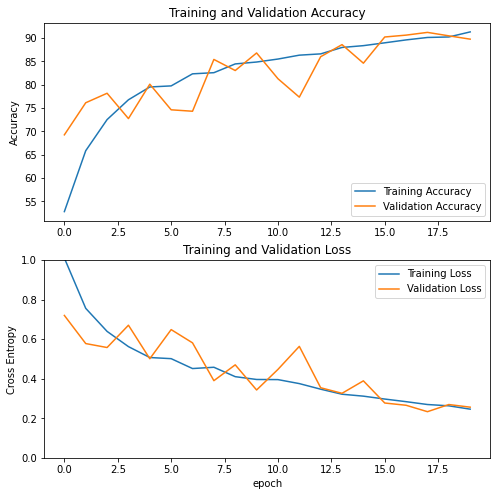

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()